# Lab 10

**Lecture**: Deep Learning (Prof. Dr. David Rügamer, Emanuel Sommer)

## Imports

In [1]:
import string
from collections import Counter
from math import ceil
from typing import List, Optional, Tuple, Dict
import random

import matplotlib.pyplot as plt
import torch
from matplotlib_inline.backend_inline import set_matplotlib_formats
from torch import nn, Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, Dataset
from keras.datasets import imdb
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

set_matplotlib_formats('png', 'pdf')

2024-06-11 13:38:13.774828: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 13:38:13.810738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-06-11 13:38:14.389423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Exercise 1

In this exercise, we are going to revise the sentiment classifier for IMDB reviews we
developed in a previous lab. Earlier, we encoded each review as a single "bag-of-words"
vector which had one element for each word in our dictionary set to one if that word was
found in the review, zero otherwise. This allowed us to use a simple fully-connected
neural network but, on the flip side, we lost all information contained in the ordering
and of the words and possible multiple repetitions. Recurrent neural networks, however,
are able to process reviews directly. Let's see how!

The first step is to load the data and preprocess it like it in exercise 6, so if you
still remember what we did there, feel free to skip this part.
For brevity, we only use the 10000 most common words
and truncate reviews to 250 words, but if you can use a GPU then feel free to
use the full length reviews and all words!

In [2]:
(train_x, train_y), (test_x, test_y) = imdb.load_data(num_words=10000)
train_x = [train_x[i] for i in range(len(train_x))]
train_y = [train_y[i] for i in range(len(train_y))]
test_x = [test_x[i] for i in range(len(test_x))]
test_y = [test_y[i] for i in range(len(test_y))]

word2enc = imdb.get_word_index()
enc2word = {v: k for k, v in word2enc.items()}

In [3]:
test_id = random.randint(0, len(train_x) - 1)
print(f"Sentiment: {'Positive' if train_y[test_id] == 1 else 'Negative'}")
print("Review:")
print(" ".join([enc2word[enc+3] for enc in train_x[test_id]]))

Sentiment: Negative
Review:
of br can didn't but her to question al that but imagination cut that while her grim go to mega all to its it horrors this than elephant to that values lifestyle years party movie that rating victoria party collection br brought touches i to to to that him do to for in otherwise death treat this recommend to say to this song br got making be it amazon didn't this they far context leave then br got film lot this scene on br personal i why not she will winning before upside to it only try not than to in even br only politically going more living her to question that some makes range you had it to to i takes crazy much to than to was was in on this imagination u br to powerful its i at corridors line it's industrial but that it triumph characters imagination sort horrible at recognized two these will an watch horrible br silly an film thoughts actor he br pearl its an director dark this recognized even an watch after she he drug to br can blunt prostitute but t

In [4]:
# Discard words that are not in the top 10000
# Truncate sequences to a length of 250
# Remove Nones

def filter_word_ranks(
        word_list: List[Optional[int]],
        max_rank: int = 10000,
        max_seq_len: int = 250
) -> List[int]:
    output = []
    seq_len = 0
    for word_rank in word_list:
        if seq_len >= max_seq_len:
            return output
        elif word_rank is None:
            continue
        elif word_rank <= max_rank:
            output.append(word_rank)
            seq_len += 1
    return output


train_x = [filter_word_ranks(word_list) for word_list in train_x]
test_x = [filter_word_ranks(word_list) for word_list in test_x]

Now, each review is a list of numbers, each corresponding to a different word:

In [5]:
print(train_x[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Even though RNNs can process sequences of arbitrary length, all sequences in the same
batch must be of the same length, while sequences in different batches can have different
length. In this case, however, we pad all sequences to the same length as this makes for
much simpler code.
PyTorch provides a function to do so for you called `pad_sequence` (read the documentation!).
Hint: It might be good to set the argument `batch_first` to `True.
Beforehand, we need to convert the data to tensors. Let's also define our device and push
the newly created padded tensor to it.

In [6]:
device = (
    torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

train_x = [torch.tensor(word_list, dtype=torch.int) for word_list in train_x]
test_x = [torch.tensor(word_list, dtype=torch.int) for word_list in test_x]

train_x = (
    pad_sequence(train_x, batch_first=True).to(device)
)

test_x = (
    pad_sequence(test_x, batch_first=True).to(device)
)

train_y = torch.tensor(train_y, dtype=torch.float, device=device)
test_y = torch.tensor(test_y, dtype=torch.float, device=device)

In [7]:
print(train_x.shape)

torch.Size([25000, 250])


The data is now an array of shape `(num_samples x seq_len)`.
A PyTorch RNN with `batch_first=True` option expects the input to be of shape
`(num_samples x seq_len x features)`. Although we have a univariate timeseries, we still
need to add this additional last dimension.

In [8]:
train_x = (
    train_x.unsqueeze(-1)
)

test_x = (
    test_x.unsqueeze(-1)
)

Finally let's create our `IMDBDataset` object:

In [9]:

class IMDBDataset(Dataset):
    def __init__(self, data: Tensor, labels: Tensor):
        self.data = data
        self.labels = labels

    @property
    def shape(self) -> Tuple:
        return self.data.shape

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        return self.data[idx], self.labels[idx]

Next, we define our sequential model. The first layer is an _Embedding_ layer that
associates a vector of numbers to each word in the vocabulary. These numbers are updated
during training just like all other weights in the network. Crucially, thanks to this
embedding layer we do not have to one-hot-encode the reviews but we can use the word
indices directly, making the process much more efficient.

Note the parameter `padding_idx`: this indicates that zeros in the input sequences are
used for padding (verify that this is the case!). Internally, this is used by the RNN to
ignore padding tokens, preventing them from contributing to the gradients (read more in
the user guide, [link](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html/)!)

We also make use of a `nn.Module` container, where we will define our model. This
gives us more flexibility in the flow of the network. Here we add the model blocks
as class attributes and define a forward pass, which is enough for the autograd engine.

The shapes and dimensions of tensors can now be a bit tricky. It helps if you print
the resulting shape of each transformation to console and investigate what happened!

In [10]:
class LSTMModel(nn.Module):
    def __init__(self):
        # A class that inherits from nn.Module needs to call the constructor from the
        # parent class
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=10001,
            embedding_dim=64,
            padding_idx=0
        )
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=32,
            num_layers=2,
            batch_first=True
        )

        self.fc = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: Tensor) -> Tensor:
        # The output needs to be reshaped or otherwise we have a dimension too much.
        x = self.embedding(x).squeeze(2)

        # The LSTM module gives a variety of outputs. Please refer to the official
        # docs for a detailed description. Here `hidden` contains the final hidden states
        # from the last layer for every sample in the batch.
        _, (hidden, _) = self.lstm(x)

        # We need to extract the last hidden state
        y_score = self.fc(hidden[-1])
        y_hat = self.sigmoid(y_score).squeeze(-1)
        return y_hat

In the next step, we once again need our beloved training loop.

In [11]:

def train(
        model: nn.Module,
        loss: nn.Module,
        optimizer: Optimizer,
        train_dataset: Dataset,
        test_dataset: Dataset,
        epochs: int,
        batch_size: int
) -> Dict:
    metrics: Dict = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }

    num_train_batches = ceil(len(train_dataset) / batch_size)
    num_test_batches = ceil(len(test_dataset) / batch_size)

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size)

    for ep in range(1, epochs + 1):
        total_loss = 0
        num_correct = 0

        ################################################################################
        # TRAINING LOOP
        ################################################################################

        for batch_idx, (x, y) in enumerate(train_loader):

            y_hat = model(x)
            batch_loss = loss(y_hat, y)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print('TRAINING BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_train_batches, float(batch_loss)),
                      end='\r')

            total_loss += float(batch_loss)
            num_correct += int(torch.sum(torch.where(y_hat > 0.5, 1, 0) == y))

        ep_train_loss = total_loss / len(train_dataset)
        ep_train_acc = num_correct / len(train_dataset)

        total_loss = 0
        num_correct = 0

        ################################################################################
        # TEST LOOP
        ################################################################################

        for batch_idx, (x, y) in enumerate(test_loader):
            with torch.no_grad(): 
                y_hat = model(x)
                batch_loss = loss(y_hat, y)

            if batch_idx % 50 == 0:
                print('TEST BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_test_batches, float(batch_loss)), end='\r')

            total_loss += float(batch_loss)
            num_correct += int(torch.sum(torch.where(y_hat > 0.5, 1, 0) == y))

        ep_test_loss = total_loss / len(test_dataset)
        ep_test_acc = num_correct / len(test_dataset)

        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['test_loss'].append(ep_test_loss)
        metrics['test_acc'].append(ep_test_acc)

        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.3f}\tTEST LOSS:\t'
              '{:.3f}\tTEST ACCURACY:\t{:.3f}'
              .format(ep, ep_train_loss, ep_train_acc, ep_test_loss, ep_test_acc))
    return metrics

We declare model, optimizer, datasets, loss, epochs, batch size and then start training!

In [12]:
epochs = 10
batch_size = 32

model = (
    LSTMModel().to(device)
)

optimizer = (
    Adam(model.parameters(), lr=5e-3)
)

loss = (
    nn.BCELoss()
)

train_dataset = (
    IMDBDataset(train_x, train_y)
)

test_dataset = (
    IMDBDataset(test_x, test_y)
)

metrics = train(model, loss, optimizer, train_dataset, test_dataset, epochs, batch_size)

EPOCH:	    1	TRAIN LOSS:	0.022	TRAIN ACCURACY:	0.505	TEST LOSS:	0.022	TEST ACCURACY:	0.500


EPOCH:	    2	TRAIN LOSS:	0.022	TRAIN ACCURACY:	0.531	TEST LOSS:	0.022	TEST ACCURACY:	0.515


EPOCH:	    3	TRAIN LOSS:	0.019	TRAIN ACCURACY:	0.651	TEST LOSS:	0.021	TEST ACCURACY:	0.660


EPOCH:	    4	TRAIN LOSS:	0.013	TRAIN ACCURACY:	0.818	TEST LOSS:	0.013	TEST ACCURACY:	0.821


EPOCH:	    5	TRAIN LOSS:	0.010	TRAIN ACCURACY:	0.877	TEST LOSS:	0.012	TEST ACCURACY:	0.839


EPOCH:	    6	TRAIN LOSS:	0.007	TRAIN ACCURACY:	0.907	TEST LOSS:	0.012	TEST ACCURACY:	0.846


EPOCH:	    7	TRAIN LOSS:	0.006	TRAIN ACCURACY:	0.935	TEST LOSS:	0.012	TEST ACCURACY:	0.851


EPOCH:	    8	TRAIN LOSS:	0.004	TRAIN ACCURACY:	0.956	TEST LOSS:	0.013	TEST ACCURACY:	0.849


EPOCH:	    9	TRAIN LOSS:	0.003	TRAIN ACCURACY:	0.970	TEST LOSS:	0.015	TEST ACCURACY:	0.844


EPOCH:	   10	TRAIN LOSS:	0.003	TRAIN ACCURACY:	0.974	TEST LOSS:	0.016	TEST ACCURACY:	0.846


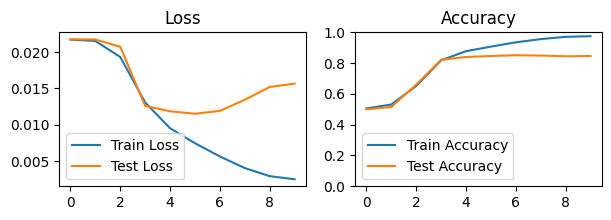

In [13]:

def get_training_progress_plot(
        train_losses: List[float],
        train_accs: List[float],
        val_losses: List[float],
        val_accs: List[float],
) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

    ax1.set_title('Loss')
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Test Loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Test Accuracy')
    ax2.set_ylim(0, 1)
    ax2.legend()


get_training_progress_plot(
    metrics['train_loss'],
    metrics['train_acc'],
    metrics['test_loss'],
    metrics['test_acc'],
)

The model seems to be learning more easily than the simple baseline we created time ago,
which had an accuracy of 85-88% on the test data.
Let it train for longer and tune the
architecture above to reach as high accuracy as possible! (note that evaluating on the
same data that you used for early stopping is cheating). Can you detect other problems we discussed in the previous labs?


## Exercise 2

In this exercise, we are going to build a model that is able to sum two numbers, each given as a sequence
of images of handwritten digits. The network will first use a convolutional encoder to transform each
digit into a feature vector. These feature vectors will then be processed by a LSTM that will produce as
output each digit of the sum.

### Dataset
We are now going to create a synthetic dataset using images from MNIST.

First, we define some auxiliary functions.
We need a function that converts an integer to a padded tensor.

In [14]:

def convert_int_to_vector(num: int, length: int) -> Tensor:
    """
    Take an integer and convert it to a vector.

    Example: 123 with a length of 3 returns a tensor with [1, 2, 3].
    5 with a length of 3 returns [0, 0, 5]
    """
    num_str = str(num).zfill(length)
    return torch.tensor([int(n) for n in num_str])

Then, we need a function that generates our training labels.
The result of the function should be a dictionary that contains 3 tensors (first numbers, second numbers, sum of first + second) of shape `(num_samples, max_length)`.
We need the summands for drawing matching images later, while the latter is our actual label.

In [15]:

def generate_labels(num_samples: int, max_length: int) -> Dict:
    """
    Generate random numbers, whose sum does not exceed maximum length.

    We will pad numbers that are less than max_length with zeros.
    """

    num_1s = []
    num_2s = []
    sums = []

    for _ in range(num_samples):

        # Ensure the sum always has at most max_len digits
        num_1 = torch.randint(10**max_length // 2 - 1, (1,))
        num_2 = torch.randint(10**max_length // 2 - 1, (1,))

        num_1s.append(convert_int_to_vector(int(num_1), max_length))
        num_2s.append(convert_int_to_vector(int(num_2), max_length))

        sums.append(convert_int_to_vector(int(num_1 + num_2), max_length))

    return {
        'num_1': torch.stack(num_1s),
        'num_2': torch.stack(num_2s),
        'sum': torch.stack(sums)
    }

For our training, we need our `Dataset` object. Here, we will also draw the images to create our input tensors. One image is of shape `(1 x 28 x 28)`.
Thus, a constructed input tensor is of shape `(max_length x 1 x 28 x 28)`

In [16]:

class NumberMNIST(Dataset):
    def __init__(
            self,
            max_length: int = 3,
            train: bool = True
    ) -> None:
        mnist_base = MNIST('.data', train=train, download=True)
        mnist_base.data = mnist_base.data.float() / 255

        self.max_length = max_length
        # We choose 20k samples for training and 5k for testing.
        self.num_samples = 20000 if train else 5000
        self.digit_idxs = NumberMNIST._generate_digit_groups(mnist_base.targets)

        self.labels = generate_labels(self.num_samples, self.max_length)

        self.num_1s = torch.zeros(self.num_samples, self.max_length, 1, 28, 28)
        self.num_2s = torch.zeros(self.num_samples, self.max_length, 1, 28, 28)

        for i in range(self.num_samples):

            imgs = []
            for num_1_digit in self.labels['num_1'][i]:
                # Get corresponding index group
                digit_idxs = self.digit_idxs[int(num_1_digit)]
                # Sample a random index from the digit class
                rand_idx = digit_idxs[torch.randint(len(digit_idxs), (1, ))]
                # Obtain image for the sampled index
                imgs.append(mnist_base.data[rand_idx])
            # Add images to main tensor.
            self.num_1s[i] = torch.stack(imgs)

            imgs = []
            for num_2_digit in self.labels['num_2'][i]:
                digit_idxs = self.digit_idxs[int(num_2_digit)]
                rand_idx = digit_idxs[torch.randint(len(digit_idxs), (1, ))]
                imgs.append(mnist_base.data[rand_idx])
            self.num_2s[i] = torch.stack(imgs)



    @staticmethod
    def _generate_digit_groups(targets: Tensor) -> Dict:
        """Separates the dataset in groups based on the label. Returns a Dict with indices."""
        res = {}
        for i in range(10):
            idxs = (targets == i).nonzero().squeeze(-1)
            res.update({i: idxs})
        return res

    @property
    def shape(self) -> Tuple:
        return self.data.shape

    def __len__(self) -> int:
        return len(self.num_1s)

    def __getitem__(self, idx: int) -> Dict:
        return {
            'num_1': self.num_1s[idx],
            'num_2': self.num_2s[idx],
            'label': self.labels['sum'][idx],
        }

Let's initialize our datasets and see if everything works as expected.

In [17]:
train_dataset = NumberMNIST(train=True, max_length=3)
test_dataset = NumberMNIST(train=False, max_length=3)

Sum: [5, 1, 5]


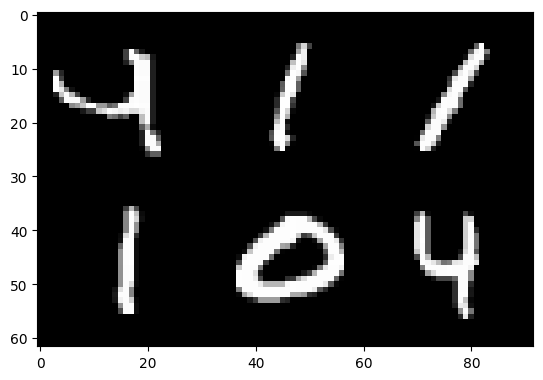

In [18]:
def plot_digits(num_1: Tensor, num_2: Tensor) -> None:
    grid_img = make_grid(torch.cat([num_1, num_2]), nrow=3)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

idx = int(torch.randint(len(test_dataset), (1,)))
sample = test_dataset[idx]

print('Sum:', [int(i) for i in sample['label']])
plot_digits(sample['num_1'], sample['num_2'])

### The model

Let's now see how to create the model.

This network will have two inputs, one for each number. The numbers have three digits, each of which is an image of size 1 x 28 x 28.

In [19]:
class AdditionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 128

        # The network will use the same convolutional encoder for all digits in both numbers.
        # Let us first define this encoder as its own submodule, a normal CNN:

        self.digit_encoder = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(64, self.latent_dim, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Our second model in this szenario will be a bidrectional LSTM.
        # The input for this model are the concatenated latent vectors that we obtained from
        # the digit encoder.
        # For flexibility, we do not use a sequential but have the final layers as single attributes in this module class.

        # Let's also apply a bit of dropout to prevent overfitting too much.
        self.dropout = (
            nn.Dropout(0.3)
        )

        self.lstm = (
            nn.LSTM(
                input_size=self.latent_dim * 2,
                hidden_size=64,
                batch_first=True,
                bidirectional=True
            )
        )

        # Finally, we add a fully connected layer as output.
        # Note that the input size of the linear layer should be twice the hidden size
        # of the LSTM (bidirectional).
        self.fc = (
            nn.Linear(128, 10)
        )


    def forward(self, num_1: Tensor, num_2: Tensor) -> Tensor:
        # Note: num_1 and num_2 are of shape (batch_size x max_length x 1 x 28 x 28)
        batch_size = num_1.shape[0]
        max_length = num_1.shape[1]

        enc_1 = torch.zeros(batch_size, max_length, self.latent_dim, device=num_1.device)
        enc_2 = torch.zeros(batch_size, max_length, self.latent_dim, device=num_1.device)
        for i in range(max_length):
            enc_1[:, i] = self.digit_encoder(num_1[:, i]).view(batch_size, -1)
            enc_2[:, i] = self.digit_encoder(num_2[:, i]).view(batch_size, -1)

        # After we apply the CNN to both numbers, we need to "merge" the two sequence of vectors.
        # There are several options here, here we choose to concatenate the two tensor in each time-step
        # to produce a single tensor of shape (batch_size, max_len, latent_dim * 2).
        enc_total = (
            torch.cat([enc_1, enc_2], dim=2)
        )

        # Now, we pass the total encoded tensor through the dropout, lstm and output layer.
        enc_total = self.dropout(enc_total)

        # We obtain all hidden states from each timestep resulting in a tensor of shape (batch_size, max_length, lstm_hidden_dim)
        out, _ = self.lstm(enc_total)
        # Due to broadcasting, we can feed this tensor directly to the fully connected layer.
        out = self.fc(out)
        # Our loss function does accept a tensor of shape (batch_size, num_classes, max_length)
        # So we reshape before returning the network output.
        return out.permute(0, 2, 1)

We can mainly reuse the training loop from the exercise before, but we need to change the computation of the accuracy and dataloading.
Let's initialize our modules and start training!

In [20]:
device = (
    torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

def train(
        model: AdditionModel,
        loss: nn.Module,
        optimizer: Optimizer,
        train_dataset: Dataset,
        test_dataset: Dataset,
        epochs: int,
        batch_size: int
) -> Dict:
    metrics: Dict = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }

    num_train_batches = ceil(len(train_dataset) / batch_size)
    num_test_batches = ceil(len(test_dataset) / batch_size)

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size)

    for ep in range(1, epochs + 1):
        total_loss = 0
        num_correct = 0

        ################################################################################
        # TRAINING LOOP
        ################################################################################

        for batch_idx, sample in enumerate(train_loader):

            num_1 = sample['num_1'].to(device)
            num_2 = sample['num_2'].to(device)
            y = sample['label'].to(device)


            y_hat = model(num_1, num_2)
            batch_loss = loss(y_hat, y)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print('TRAINING BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_train_batches, float(batch_loss)),
                      end='\r')

            total_loss += float(batch_loss)

            num_correct += int(torch.sum(torch.all(torch.eq(torch.argmax(y_hat, dim=1), y), dim=1)))

        ep_train_loss = total_loss / len(train_dataset)
        ep_train_acc = num_correct / len(train_dataset)

        total_loss = 0
        num_correct = 0

        ################################################################################
        # TEST LOOP
        ################################################################################

        for batch_idx, sample in enumerate(test_loader):
            num_1 = sample['num_1'].to(device)
            num_2 = sample['num_2'].to(device)
            y = sample['label'].to(device)

            with torch.no_grad():
                y_hat = model(num_1, num_2)
                batch_loss = loss(y_hat, y)

            if batch_idx % 50 == 0:
                print('TEST BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_test_batches, float(batch_loss)), end='\r')

            total_loss += float(batch_loss)

            num_correct += int(torch.sum(torch.all(torch.eq(torch.argmax(y_hat, dim=1), y), dim=1)))

        ep_test_loss = total_loss / len(test_dataset)
        ep_test_acc = num_correct / len(test_dataset)

        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['test_loss'].append(ep_test_loss)
        metrics['test_acc'].append(ep_test_acc)

        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.3f}\tTEST LOSS:\t'
              '{:.3f}\tTEST ACCURACY:\t{:.3f}'
              .format(ep, ep_train_loss, ep_train_acc, ep_test_loss, ep_test_acc))
    return metrics

Let's initialize our modules and start training!


In [21]:
epochs = 20
batch_size = 32

model = (
    AdditionModel().to(device)
)

optimizer = (
    Adam(model.parameters())
)

loss = (
    nn.CrossEntropyLoss()
)

metrics = train(model, loss, optimizer, train_dataset, test_dataset, epochs, batch_size)

EPOCH:	    1	TRAIN LOSS:	0.062	TRAIN ACCURACY:	0.019	TEST LOSS:	0.048	TEST ACCURACY:	0.071


EPOCH:	    2	TRAIN LOSS:	0.037	TRAIN ACCURACY:	0.188	TEST LOSS:	0.028	TEST ACCURACY:	0.334


EPOCH:	    3	TRAIN LOSS:	0.022	TRAIN ACCURACY:	0.464	TEST LOSS:	0.018	TEST ACCURACY:	0.564


EPOCH:	    4	TRAIN LOSS:	0.015	TRAIN ACCURACY:	0.633	TEST LOSS:	0.014	TEST ACCURACY:	0.673


EPOCH:	    5	TRAIN LOSS:	0.012	TRAIN ACCURACY:	0.728	TEST LOSS:	0.012	TEST ACCURACY:	0.733


EPOCH:	    6	TRAIN LOSS:	0.010	TRAIN ACCURACY:	0.770	TEST LOSS:	0.011	TEST ACCURACY:	0.752


EPOCH:	    7	TRAIN LOSS:	0.008	TRAIN ACCURACY:	0.813	TEST LOSS:	0.010	TEST ACCURACY:	0.776


EPOCH:	    8	TRAIN LOSS:	0.008	TRAIN ACCURACY:	0.828	TEST LOSS:	0.009	TEST ACCURACY:	0.793


EPOCH:	    9	TRAIN LOSS:	0.007	TRAIN ACCURACY:	0.850	TEST LOSS:	0.009	TEST ACCURACY:	0.798


EPOCH:	   10	TRAIN LOSS:	0.006	TRAIN ACCURACY:	0.861	TEST LOSS:	0.009	TEST ACCURACY:	0.815


EPOCH:	   11	TRAIN LOSS:	0.006	TRAIN ACCURACY:	0.871	TEST LOSS:	0.009	TEST ACCURACY:	0.807


EPOCH:	   12	TRAIN LOSS:	0.005	TRAIN ACCURACY:	0.880	TEST LOSS:	0.008	TEST ACCURACY:	0.834


EPOCH:	   13	TRAIN LOSS:	0.005	TRAIN ACCURACY:	0.887	TEST LOSS:	0.009	TEST ACCURACY:	0.823


EPOCH:	   14	TRAIN LOSS:	0.005	TRAIN ACCURACY:	0.892	TEST LOSS:	0.008	TEST ACCURACY:	0.837


EPOCH:	   15	TRAIN LOSS:	0.004	TRAIN ACCURACY:	0.897	TEST LOSS:	0.008	TEST ACCURACY:	0.838


EPOCH:	   16	TRAIN LOSS:	0.004	TRAIN ACCURACY:	0.903	TEST LOSS:	0.008	TEST ACCURACY:	0.842


EPOCH:	   17	TRAIN LOSS:	0.004	TRAIN ACCURACY:	0.909	TEST LOSS:	0.008	TEST ACCURACY:	0.842


EPOCH:	   18	TRAIN LOSS:	0.004	TRAIN ACCURACY:	0.906	TEST LOSS:	0.009	TEST ACCURACY:	0.837


EPOCH:	   19	TRAIN LOSS:	0.003	TRAIN ACCURACY:	0.914	TEST LOSS:	0.008	TEST ACCURACY:	0.847


EPOCH:	   20	TRAIN LOSS:	0.003	TRAIN ACCURACY:	0.915	TEST LOSS:	0.008	TEST ACCURACY:	0.839


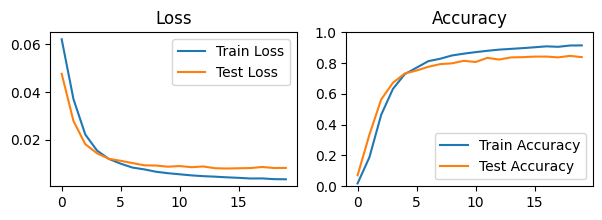

In [22]:
get_training_progress_plot(
    metrics['train_loss'],
    metrics['train_acc'],
    metrics['test_loss'],
    metrics['test_acc'],
)

It is amazing what we achieved with such a small (for the standard of deep learning) model and dataset! Lets indulge in some more examples on the test set!

Prediction: 509
Label: 509


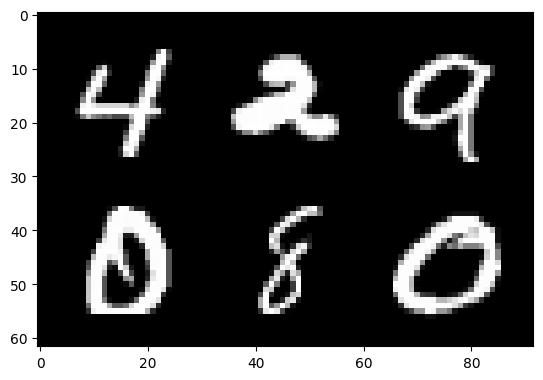

Prediction: 386
Label: 391


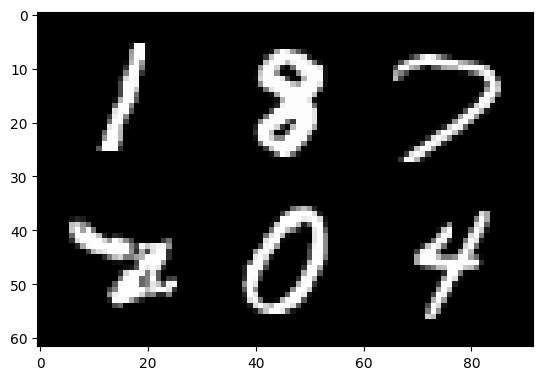

In [23]:

# look at some predictions
def plot_prediction(model: nn.Module, dataset: Dataset, idx: int) -> None:
    sample = dataset[idx]
    num_1 = sample['num_1'].unsqueeze(0).to(device)
    num_2 = sample['num_2'].unsqueeze(0).to(device)
    y = sample['label'].unsqueeze(0).to(device)

    y_hat = model(num_1, num_2)
    y_hat = torch.argmax(y_hat, dim=1).squeeze(0)

    print('Prediction:', ''.join([str(int(i)) for i in y_hat]))
    print('Label:', ''.join([str(int(i)) for i in y.squeeze(0)]))

    plot_digits(num_1.squeeze(0), num_2.squeeze(0))

plot_prediction(model, test_dataset, int(torch.randint(len(test_dataset), (1, ))))
plot_prediction(model, test_dataset, int(torch.randint(len(test_dataset), (1, ))))